[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ZuchniakK/LitterMoistureEstimation/blob/main/5_xgboost_pct.ipynb)

### Gradient Boosting Machine

#### In addition to deep learning, We also checked how the gradient boosting machine works in this problem. The XGBoost library was selected, time series of different lengths were flattened and concatenated, similarly to the preparation of input data for MLP type networks. I got surprisingly good results, even better than using ensemble of deep learning models. Here, too, I used the search for hyperparameters using the Optuna framework, GBM has a lot of control parameters and their proper selection has a significant impact on the performance of the regressor. Manually selected metaparameters led to training the model with MDAPE (Median Absolute Percentage Error) 11.7%, while after tuning hyperparameters I got 10.5%

In [82]:
import sys

sys.path.append("..")

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import optuna
import tensorflow as tf
from litter import WindowGenerator
from matplotlib.gridspec import GridSpec
from optuna.integration import TFKerasPruningCallback
from scipy.stats import gaussian_kde
from xgboost import XGBRegressor

In [ ]:
tf.config.list_physical_devices("GPU")

In [83]:
plt.rcParams["figure.figsize"] = (15, 10)
plt.style.use("bmh")

In [2]:
# WindowGenerator params
DATA_PATH = "../stations"
SCALING = "standarization"  # 'normalization'
GAP_STRATEGY = "linear"
FIRST_SEASON = 2015
FIRST_VAL_SEASON = 2021
FIRST_TEST_SEASON = 2022
LAST_TEST_SEASON = 2022

# data generator params
FEATURES = [
    "air_temperature_50cm",
    "air_temperature_200cm",
    "air_humidity_50cm",
    "air_humidity_200cm",
    "wind_x",
    "wind_y",
    "max_wind_x",
    "max_wind_y",
    "temporary_rainfall",
    "total_precipitation",
    "day_sin",
    "day_cos",
    "year_sin",
    "year_cos",
]
DATA_FORMAT = "channels_last"
INTERVALS = [3, 6, 6 * 2, 6 * 4, 6 * 24, 6 * 24 * 12]
BASE_SEQ_LEN = 30
OTHER_SEQ_LEN = [30, 30, 30, 30, 30, 30]
INCLUDE_COORDS = True
USE_PREVIOUS_Y = True
REPLACE = False

# training params
BATCH_SIZE = 32

In [21]:
wg = WindowGenerator(
    data_path=DATA_PATH,
    scaling=SCALING,
    gap_strategy=GAP_STRATEGY,
    first_train_season=FIRST_SEASON,
    first_val_season=FIRST_VAL_SEASON,
    first_test_season=FIRST_TEST_SEASON,
    last_test_season=LAST_TEST_SEASON,
)

In [22]:
(train_x, train_y), (val_x, val_y), (test_x, test_y), length_stats = wg.get_data(
    batch_size=BATCH_SIZE,
    data_format=DATA_FORMAT,
    intervals=INTERVALS,
    base_seq_len=BASE_SEQ_LEN,
    other_seq_len=OTHER_SEQ_LEN,
    features_cols=FEATURES,
    include_coords=INCLUDE_COORDS,
    use_previous_y=USE_PREVIOUS_Y,
    replace=REPLACE,
    train_generator=False,
    val_generator=False,
    test_generator=False,
)

data format: channels_last
1985
1985 1985 1985
1084
1084 1084 1084
1875
1875 1875 1875
1493
1493 1493 1493
1775
1775 1775 1775
1295
1295 1295 1295
1885
1885 1885 1885
647
647 647 647
1945
1945 1945 1945
1209
1209 1209 1209
2035
2035 2035 2035
1673
1673 1673 1673
1859
1859 1859 1859
1338
1338 1338 1338
1773
1773 1773 1773
714
714 714 714
942
942 942 942
713
713 713 713
1003
1003 1003 1003
755
755 755 755
2003
2003 2003 2003
1520
1520 1520 1520
1879
1879 1879 1879
907
907 907 907
2013
2013 2013 2013
1444
1444 1444 1444
1889
1889 1889 1889
1270
1270 1270 1270
1814
1814 1814 1814
832
832 832 832
1766
1766 1766 1766
854
854 854 854
879
879 879 879
505
505 505 505
1813
1813 1813 1813
1388
1388 1388 1388
266
266 266 266
219
219 219 219
887
887 887 887
840
840 840 840
998
998 998 998
354
354 354 354
641
641 641 641
370
370 370 370
1807
1807 1807 1807
1298
1298 1298 1298
1197
1197 1197 1197
750
750 750 750
624
624 624 624
370
370 370 370
1733
1733 1733 1733
1221
1221 1221 1221
1824
1824 1824 18

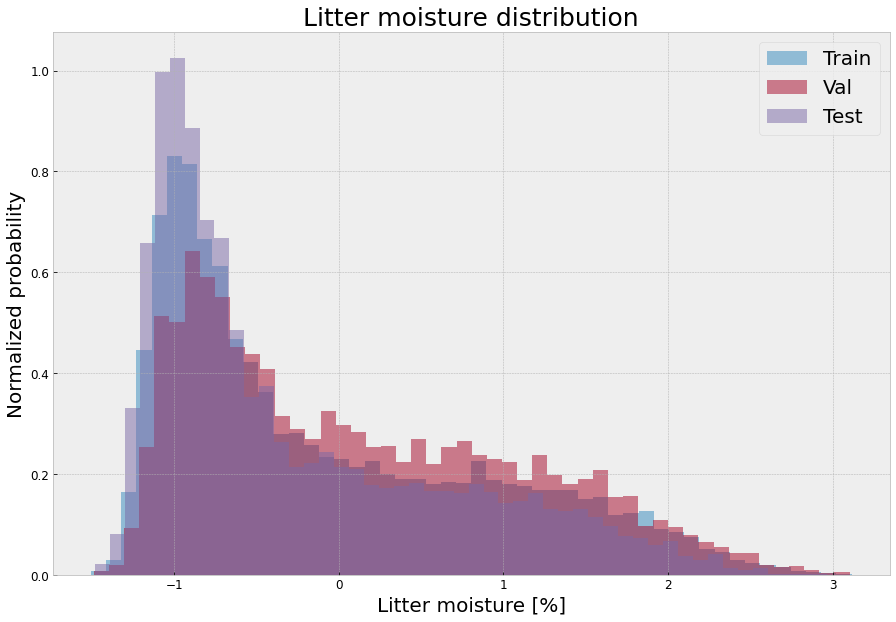

In [34]:
fig, ax = plt.subplots()

ax.hist(train_y, bins=50, density=True, label="Train", alpha=0.5)
ax.hist(val_y, bins=50, density=True, label="Val", alpha=0.5)
ax.hist(test_y, bins=50, density=True, label="Test", alpha=0.5)

plt.title("Litter moisture distribution", fontsize=25)
ax.tick_params(axis="both", which="major", labelsize=12)
ax.set_xlabel("Litter moisture [%]", fontsize=20)
ax.set_ylabel("Normalized probability", fontsize=20)
plt.legend(fontsize=20)
plt.savefig("litter_moisture_distribution_lstm.svg")

In [23]:
if SCALING == "normalization":
    train_y = (
        (wg.train_max["litter_moisture"] - wg.train_min["litter_moisture"]) * train_y
    ) + wg.train_min["litter_moisture"]
    val_y = (
        wg.train_max["litter_moisture"] - wg.train_min["litter_moisture"]
    ) * val_y + wg.train_min["litter_moisture"]
    test_y = (
        wg.train_max["litter_moisture"] - wg.train_min["litter_moisture"]
    ) * test_y + wg.train_min["litter_moisture"]

    y_morning_train = (
        wg.train_max["litter_moisture"] - wg.train_min["litter_moisture"]
    ) * train_x[0][:, 0] + wg.train_min["litter_moisture"]
    y_morning_val = (
        wg.train_max["litter_moisture"] - wg.train_min["litter_moisture"]
    ) * val_x[0][:, 0] + wg.train_min["litter_moisture"]
    y_morning_test = (
        wg.train_max["litter_moisture"] - wg.train_min["litter_moisture"]
    ) * test_x[0][:, 0] + wg.train_min["litter_moisture"]

elif SCALING == "standarization":
    train_y = (
        train_y * wg.train_std["litter_moisture"] + wg.train_mean["litter_moisture"]
    )
    val_y = val_y * wg.train_std["litter_moisture"] + wg.train_mean["litter_moisture"]
    test_y = test_y * wg.train_std["litter_moisture"] + wg.train_mean["litter_moisture"]

    y_morning_train = (
        train_x[0][:, 0] * wg.train_std["litter_moisture"]
        + wg.train_mean["litter_moisture"]
    )
    y_morning_val = (
        val_x[0][:, 0] * wg.train_std["litter_moisture"]
        + wg.train_mean["litter_moisture"]
    )
    y_morning_test = (
        test_x[0][:, 0] * wg.train_std["litter_moisture"]
        + wg.train_mean["litter_moisture"]
    )

else:
    y_morning_train = train_x[0][:, 0]
    y_morning_val = val_x[0][:, 0]
    y_morning_test = test_x[0][:, 0]

pct_change_train = (train_y - y_morning_train) / y_morning_train * 100
pct_change_val = (val_y - y_morning_val) / y_morning_val * 100
pct_change_test = (test_y - y_morning_test) / y_morning_test * 100

pct_change_mean = pct_change_train.mean()
pct_change_std = pct_change_train.std()

pct_change_standarized_train = (pct_change_train - pct_change_mean) / pct_change_std
pct_change_standarized_val = (pct_change_val - pct_change_mean) / pct_change_std
pct_change_standarized_test = (pct_change_test - pct_change_mean) / pct_change_std

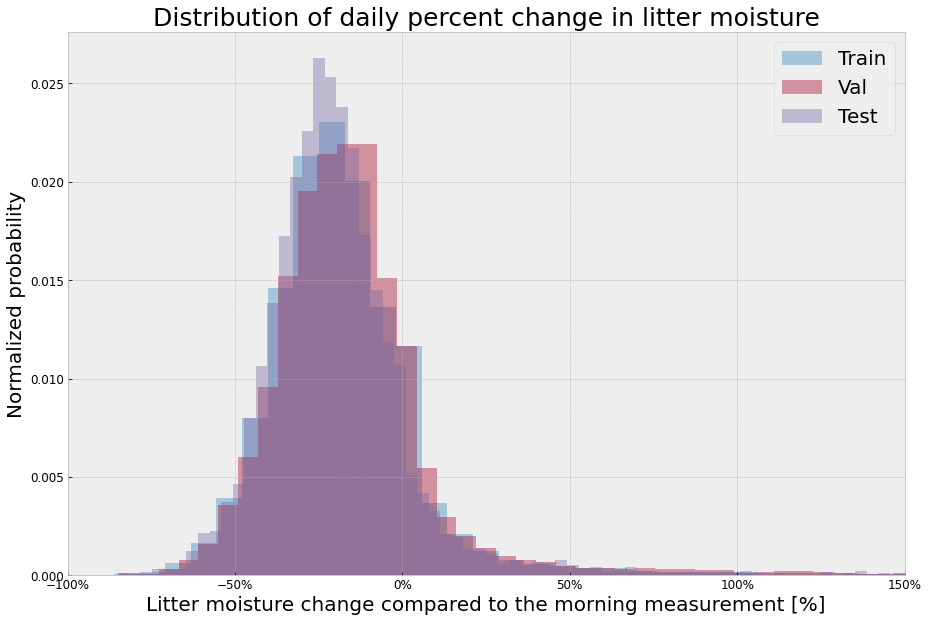

In [36]:
fig, ax = plt.subplots()

ax.hist(pct_change_train, bins=150, density=True, label="Train", alpha=0.4)
ax.hist(pct_change_val, bins=150, density=True, label="Val", alpha=0.4)
ax.hist(pct_change_test, bins=150, density=True, label="Test", alpha=0.4)

plt.xlim([-100, 150])
plt.title("Distribution of daily percent change in litter moisture", fontsize=25)
ax.tick_params(axis="both", which="major", labelsize=12)
ax.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=100))
ax.set_xlabel(
    "Litter moisture change compared to the morning measurement [%]", fontsize=20
)
ax.set_ylabel("Normalized probability", fontsize=20)
plt.legend(fontsize=20)
plt.savefig("litter_moisture_change_lstm.svg")

In [25]:
train_x = np.concatenate([arr.reshape((arr.shape[0], -1)) for arr in train_x], axis=-1)
val_x = np.concatenate([arr.reshape((arr.shape[0], -1)) for arr in val_x], axis=-1)
test_x = np.concatenate([arr.reshape((arr.shape[0], -1)) for arr in test_x], axis=-1)

In [ ]:
xgb_model = XGBRegressor(
    n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8
)
xgb_model.fit(train_x, pct_change_standarized_train)

In [58]:
xgb_model.save_model("xgb1.model")

In [55]:
y_pred = xgb_model.predict(test_x)

In [57]:
pct_change_predicted = y_pred * pct_change_std + pct_change_mean

y_real = y_morning_test * (1 + pct_change_test / 100)
y_pred = y_morning_test * (1 + pct_change_predicted / 100)

mae = np.absolute(y_real - y_pred).mean()
rmsd = (((y_real - y_pred) ** 2).mean()) ** 0.5
mape = np.abs((y_real - y_pred) / y_real).mean() * 100
mdape = np.median(np.abs((y_real - y_pred) / y_real)) * 100
print(mae, rmsd, mape, mdape)

3.4827758734625966 5.253078149811914 16.714888492485358 11.674233478143682


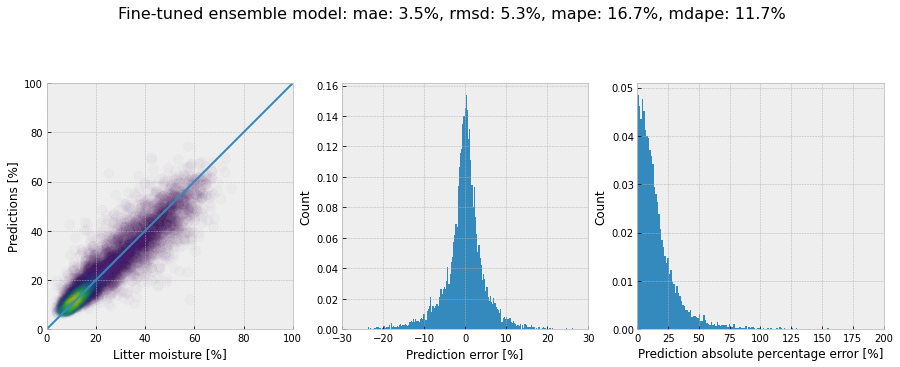

In [43]:
from scipy.stats import gaussian_kde

# Calculate the point density
xy = np.vstack([y_real, y_pred])
z = gaussian_kde(xy)(xy)


fig, ax = plt.subplots(nrows=1, ncols=3)
_ = fig.suptitle(
    f"Fine-tuned ensemble model: mae: {round(mae, 1)}%, rmsd: {round(rmsd, 1)}%, mape: {round(mape,1)}%, mdape: {round(mdape,1)}%",
    fontsize=16,
    y=0.78,
)

_ = ax[0].set_aspect("equal")
ax[0].scatter(y_real, y_pred, c=z, s=100, alpha=0.02)
ax[0].set_xlabel("Litter moisture [%]")
ax[0].set_ylabel("Predictions [%]")
lims = [0, 100]
ax[0].plot(lims, lims)
_ = ax[0].axis(xmin=0, xmax=100, ymin=0, ymax=100)


error = y_pred - y_real
ax[1].hist(error, bins=300, density=True)
ax[1].set_xlim([-30, 30])
ax[1].set_xlabel("Prediction error [%]")
_ = ax[1].set_ylabel("Count")
asp = np.diff(ax[1].get_xlim())[0] / np.diff(ax[1].get_ylim())[0]
_ = ax[1].set_aspect(asp)


error = np.absolute((y_pred - y_real) / y_real) * 100
ax[2].hist(error, bins=300, density=True)
ax[2].set_xlim([0, 200])
ax[2].set_xlabel("Prediction absolute percentage error [%]")
_ = ax[2].set_ylabel("Count")
asp = np.diff(ax[2].get_xlim())[0] / np.diff(ax[2].get_ylim())[0]
_ = ax[2].set_aspect(asp)


plt.savefig("litter_moisture_lstm_test_finetuned2_ensemble.svg")

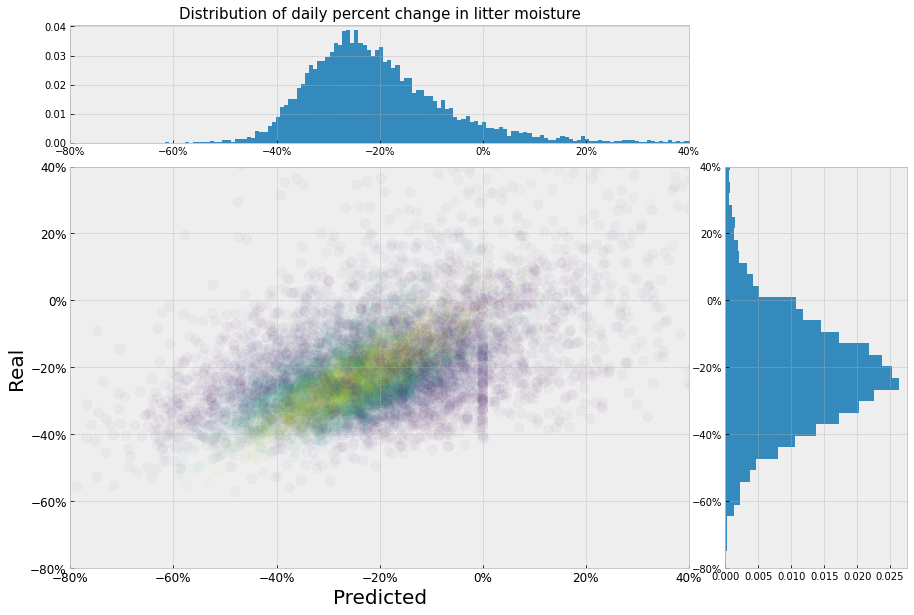

<Figure size 1080x720 with 0 Axes>

In [44]:
fig = plt.figure()
gs = GridSpec(4, 4)

ax_scatter = fig.add_subplot(gs[1:4, 0:3])
ax_hist_y = fig.add_subplot(gs[0, 0:3])
ax_hist_x = fig.add_subplot(gs[1:4, 3])

ax_scatter.scatter(pct_change_test, pct_change_predicted, c=z, s=100, alpha=0.03)
ax_hist_x.hist(pct_change_test, orientation="horizontal", bins=150, density=True)
ax_hist_y.hist(pct_change_predicted, bins=500, density=True)

ax_scatter.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=100))
ax_scatter.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=100))
ax_hist_y.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=100))
ax_hist_x.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=100))
ax_scatter.set_ylabel("Real", fontsize=20)
ax_scatter.set_xlabel("Predicted", fontsize=20)

min_val, max_val = -80, 40
ax_scatter.set_xlim([min_val, max_val])
ax_scatter.set_ylim([min_val, max_val])
ax_hist_y.set_xlim([min_val, max_val])
ax_hist_x.set_ylim([min_val, max_val])
ax_hist_y.set_title(
    "Distribution of daily percent change in litter moisture", fontsize=15
)
ax_scatter.tick_params(axis="both", which="major", labelsize=12)
ax_scatter.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=100))

plt.show()
plt.savefig("results_boundary_pct_change_distribution_finetuned2_ensemble.svg")

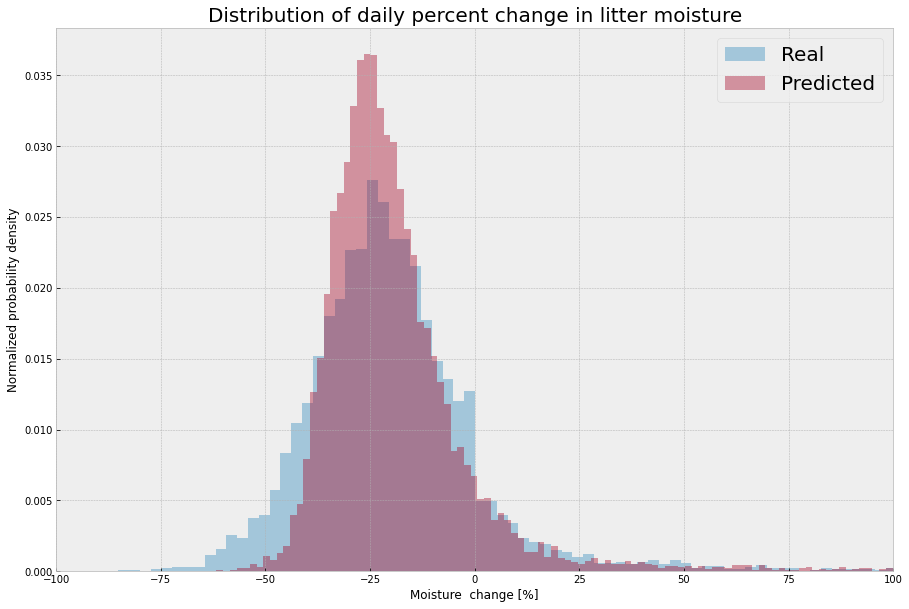

In [45]:
_ = plt.hist(pct_change_test, bins=200, density=True, alpha=0.4, label="Real")
_ = plt.hist(pct_change_predicted, bins=250, density=True, alpha=0.4, label="Predicted")
plt.legend(fontsize=20)
plt.xlim([-100, 100])
plt.xlabel("Moisture  change [%]")
plt.ylabel("Normalized probability density")
_ = plt.title("Distribution of daily percent change in litter moisture", fontsize=20)

In [110]:
# TODO
# The method of saving to file is not the best idea,
# but for experimental purposes it is sufficient and the fastest in implementation.
# Unfortunately, there are no convenient methods to store information about the best value obtained in the optuna "trial" variable.
f = open("best_mdape_xgb_pct_std.txt", "w")
f.write("10000")
f.close()

In [127]:
def objective(trial):

    param = {
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        "verbosity": 0,  # 0 (silent) - 3 (debug)
        "objective": "reg:squarederror",
        "lambda": trial.suggest_float("lambda", 1e-3, 10.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-3, 10.0, log=True),
        "gamma": trial.suggest_float("gamma", 1e-8, 10.0, log=True),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.3, 1.0),
        "subsample": trial.suggest_float("subsample", 0.4, 1.0),
        "learning_rate": trial.suggest_float("learning_rate", 0.0001, 0.1, log=True),
        "n_estimators": 1000,
        "max_depth": trial.suggest_int("max_depth", 4, 18),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 300),
        "early_stopping_rounds": 50,
    }

    xgb_model = XGBRegressor(**param)
    pruning_callback = optuna.integration.XGBoostPruningCallback(
        trial, "validation_0-rmse"
    )
    xgb_model.fit(
        train_x,
        pct_change_standarized_train,
        eval_set=[(val_x, pct_change_standarized_val)],
        verbose=False,
        callbacks=[pruning_callback],
    )

    y_pred = xgb_model.predict(test_x)

    pct_change_predicted = y_pred * pct_change_std + pct_change_mean
    y_real = y_morning_test * (1 + pct_change_test / 100)
    y_pred = y_morning_test * (1 + pct_change_predicted / 100)

    mae = np.absolute(y_real - y_pred).mean()
    rmsd = (((y_real - y_pred) ** 2).mean()) ** 0.5
    mape = np.abs((y_real - y_pred) / y_real).mean() * 100
    mdape = np.median(np.abs((y_real - y_pred) / y_real)) * 100
    print(mae, rmsd, mape, mdape)

    f = open("best_mdape_xgb_pct_std.txt", "r")
    best_mdape = float(f.read())
    f.close()

    if mae + mdape < best_mdape:
        print("save model")
        best_mdape = mae + mdape
        xgb_model.save_model("best_xgb3.model")
        f = open("best_mdape_xgb_pct_std.txt", "w")
        f.write(str(best_mdape))
        f.close()

    return mae + mdape

In [ ]:
study = optuna.create_study(
    pruner=optuna.pruners.MedianPruner(n_warmup_steps=50), direction="minimize"
)
study.optimize(objective, n_trials=10000)

[I 2022-10-19 19:04:26,062] A new study created in memory with name: no-name-f51fa2b5-c90b-4dfb-85d2-26827fdfa859
[I 2022-10-19 19:12:32,719] Trial 0 finished with value: 14.032073806268253 and parameters: {'booster': 'gbtree', 'lambda': 1.577676195368448, 'alpha': 4.641865082562011, 'gamma': 0.00022672539343588486, 'colsample_bytree': 0.7872105822299669, 'subsample': 0.5652214963868207, 'learning_rate': 0.00566469920790916, 'max_depth': 6, 'min_child_weight': 222}. Best is trial 0 with value: 14.032073806268253.


3.27441552299612 4.99800585517327 15.848771603208444 10.757658283272132
save model


In [80]:
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials:  118
Best trial:
  Value:  13.669727602027363
  Params: 
    booster: dart
    lambda: 0.06861910075739551
    alpha: 0.010540896196333863
    gamma: 1.2201601168719998
    colsample_bytree: 0.8534677435976368
    subsample: 0.8657758074092462
    learning_rate: 0.017325031353956747
    max_depth: 12
    min_child_weight: 168


In [90]:
param = {
    "verbosity": 1,
    "objective": "reg:squarederror",
    "n_estimators": 10000,
    "early_stopping_rounds": 100,
    **study.best_trial.params,
}
xgb_model = XGBRegressor(**param)
xgb_model.fit(
    train_x,
    pct_change_standarized_train,
    eval_set=[(val_x, pct_change_standarized_val)],
)

[0]	validation_0-rmse:1.17350
[1]	validation_0-rmse:1.16252
[2]	validation_0-rmse:1.15166
[3]	validation_0-rmse:1.14116
[4]	validation_0-rmse:1.13097
[5]	validation_0-rmse:1.12070
[6]	validation_0-rmse:1.11099
[7]	validation_0-rmse:1.10136
[8]	validation_0-rmse:1.09198
[9]	validation_0-rmse:1.08261
[10]	validation_0-rmse:1.07391
[11]	validation_0-rmse:1.06507
[12]	validation_0-rmse:1.05656
[13]	validation_0-rmse:1.04807
[14]	validation_0-rmse:1.04010
[15]	validation_0-rmse:1.03219
[16]	validation_0-rmse:1.02435
[17]	validation_0-rmse:1.01676
[18]	validation_0-rmse:1.00950
[19]	validation_0-rmse:1.00226
[20]	validation_0-rmse:0.99535
[21]	validation_0-rmse:0.98968
[22]	validation_0-rmse:0.98426
[23]	validation_0-rmse:0.97769
[24]	validation_0-rmse:0.97145
[25]	validation_0-rmse:0.96512
[26]	validation_0-rmse:0.95902
[27]	validation_0-rmse:0.95295
[28]	validation_0-rmse:0.94701
[29]	validation_0-rmse:0.94147
[30]	validation_0-rmse:0.93597
[31]	validation_0-rmse:0.93066
[32]	validation_0-

XGBRegressor(alpha=0.010540896196333863, base_score=0.5, booster='dart',
             callbacks=None, colsample_bylevel=1, colsample_bynode=1,
             colsample_bytree=0.8534677435976368, early_stopping_rounds=100,
             enable_categorical=False, eval_metric=None,
             gamma=1.2201601168719998, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             lambda=0.06861910075739551, learning_rate=0.017325031353956747,
             max_bin=256, max_cat_to_onehot=4, max_delta_step=0, max_depth=12,
             max_leaves=0, min_child_weight=168, missing=nan,
             monotone_constraints='()', n_estimators=10000, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [103]:
best_xgb = XGBRegressor()
best_xgb.load_model("best_xgb2.model")

In [91]:
xgb_model.save_model("best_xgb_big.model")

In [107]:
y_pred = best_xgb.predict(test_x)

In [108]:
pct_change_predicted = y_pred * pct_change_std + pct_change_mean

y_real = y_morning_test * (1 + pct_change_test / 100)
y_pred = y_morning_test * (1 + pct_change_predicted / 100)

mae = np.absolute(y_real - y_pred).mean()
rmsd = (((y_real - y_pred) ** 2).mean()) ** 0.5
mape = np.abs((y_real - y_pred) / y_real).mean() * 100
mdape = np.median(np.abs((y_real - y_pred) / y_real)) * 100
print(mae, rmsd, mape, mdape)

3.2129567271220156 4.920410782332579 15.591667628056797 10.456770874905347


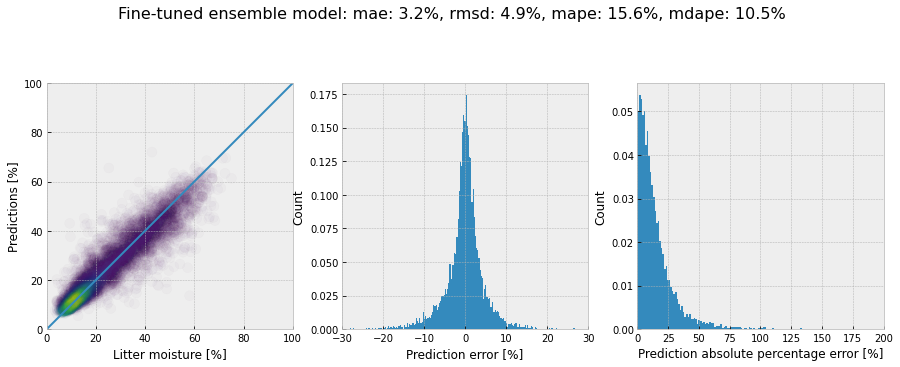

In [109]:
from scipy.stats import gaussian_kde

# Calculate the point density
xy = np.vstack([y_real, y_pred])
z = gaussian_kde(xy)(xy)


fig, ax = plt.subplots(nrows=1, ncols=3)
_ = fig.suptitle(
    f"Fine-tuned ensemble model: mae: {round(mae, 1)}%, rmsd: {round(rmsd, 1)}%, mape: {round(mape,1)}%, mdape: {round(mdape,1)}%",
    fontsize=16,
    y=0.78,
)

_ = ax[0].set_aspect("equal")
ax[0].scatter(y_real, y_pred, c=z, s=100, alpha=0.02)
ax[0].set_xlabel("Litter moisture [%]")
ax[0].set_ylabel("Predictions [%]")
lims = [0, 100]
ax[0].plot(lims, lims)
_ = ax[0].axis(xmin=0, xmax=100, ymin=0, ymax=100)


error = y_pred - y_real
ax[1].hist(error, bins=300, density=True)
ax[1].set_xlim([-30, 30])
ax[1].set_xlabel("Prediction error [%]")
_ = ax[1].set_ylabel("Count")
asp = np.diff(ax[1].get_xlim())[0] / np.diff(ax[1].get_ylim())[0]
_ = ax[1].set_aspect(asp)


error = np.absolute((y_pred - y_real) / y_real) * 100
ax[2].hist(error, bins=300, density=True)
ax[2].set_xlim([0, 200])
ax[2].set_xlabel("Prediction absolute percentage error [%]")
_ = ax[2].set_ylabel("Count")
asp = np.diff(ax[2].get_xlim())[0] / np.diff(ax[2].get_ylim())[0]
_ = ax[2].set_aspect(asp)


plt.savefig("litter_moisture_xgb.svg")